In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

In [4]:
def fit_bootstrap(p0, datax, datay, function, yerr_systematic=0.0):

    errfunc = lambda p, x, y: function(x,p) - y

    # Fit first time
    pfit, perr = optimize.leastsq(errfunc, p0, args=(datax, datay), full_output=0)


    # Get the stdev of the residuals
    residuals = errfunc(pfit, datax, datay)
    sigma_res = np.std(residuals)

    sigma_err_total = np.sqrt(sigma_res**2 + yerr_systematic**2)

    # 100 random data sets are generated and fitted
    ps = []
    for i in range(100):

        randomDelta = np.random.normal(0., sigma_err_total, len(datay))
        randomdataY = datay + randomDelta

        randomfit, randomcov = \
            optimize.leastsq(errfunc, p0, args=(datax, randomdataY),\
                             full_output=0)

        ps.append(randomfit) 

    ps = np.array(ps)
    mean_pfit = np.mean(ps,0)

    # You can choose the confidence interval that you want for your
    # parameter estimates: 
    Nsigma = 1. # 1sigma gets approximately the same as methods above
                # 1sigma corresponds to 68.3% confidence interval
                # 2sigma corresponds to 95.44% confidence interval
    err_pfit = Nsigma * np.std(ps,0) 

    pfit_bootstrap = mean_pfit
    perr_bootstrap = err_pfit
    return pfit_bootstrap, perr_bootstrap 

def sigmoid(x, pars):
    pendenza = pars[0]
    massimo = pars[1]
    flesso = pars[2]
    return massimo / (1 + np.exp(-(x-flesso)*pendenza)) 

In [9]:
df = pd.read_csv("COVID-19/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv", index_col=0)
df.index = pd.to_datetime(df.index)
#df['grad']=np.gradient(df['totale_casi'])
#df['grad'].plot(title="Nuovi casi Covid-19")

In [10]:
pstart = [2.43758048e-01, 4.31177862e+04, 1.95312145e+01]

xdata = np.arange(len(df))+1
ydata = df['totale_casi']
          
pfit, perr = fit_bootstrap(pstart, xdata, ydata, sigmoid)

([<matplotlib.axis.XTick at 0x101f635710>,
 <a list of 3 Text xticklabel objects>)

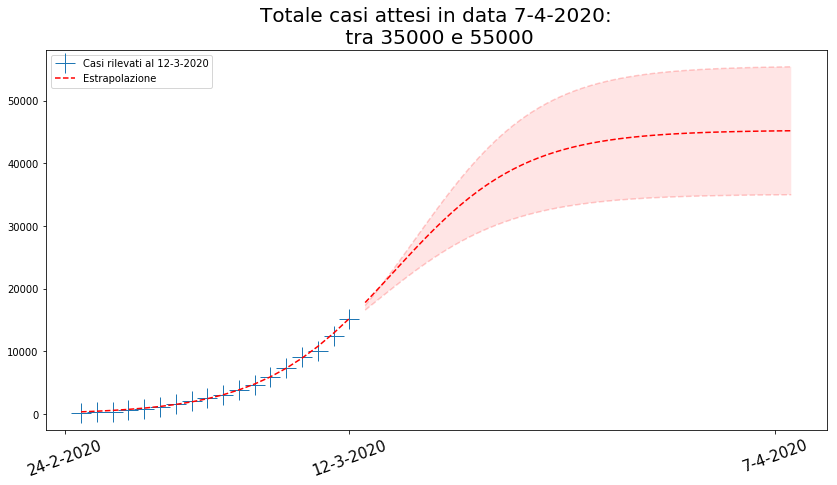

In [6]:
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111)
# i dati
data_rilev =  str(df.index[-1].day) + "-" + str(df.index[-1].month) + "-" + str(df.index[-1].year)
ax.plot(xdata, ydata, '+', markersize=20, label = f"Casi rilevati al {data_rilev}")
# il fit sui dati
ysim = sigmoid(xdata, pfit)
ax.plot(xdata, ysim, '--', c = 'r')

# l'estrapolazione
xsim = np.linspace (len(xdata), 2.5*len(xdata))+1
ysim = sigmoid(xsim, pfit)
ax.plot(xsim, ysim, '--', c = 'r', label="Estrapolazione")


# l'estrapolazione superiore
ysim_sup = sigmoid(xsim, pfit+perr)
ax.plot(xsim, ysim_sup, '--', c = 'r', alpha = 0.2)

ysim_inf = sigmoid(xsim, pfit-perr)
ax.plot(xsim, ysim_inf, '--', c = 'r', alpha = 0.2)
plt.fill_between(xsim, ysim_sup, ysim_inf, facecolor="red", alpha=0.1)
attesi_inf = int(np.round(ysim_inf[-1], decimals=-3))
attesi_sup = int(np.round(ysim_sup[-1], decimals=-3))

terzo_tick = df.index[-1] + 1.5*(df.index[-1]-df.index[0])
terzo_tick2print = str(terzo_tick.day) + "-" + str(terzo_tick.month) + "-" + str(terzo_tick.year) 
plt.title(f"Totale casi attesi in data {terzo_tick2print}:\n tra {attesi_inf} e {attesi_sup}", size=20)
plt.legend()

dates2plot = [str(df.index[0].day) + "-" + str(df.index[0].month) + "-" + str(df.index[0].year),
              data_rilev,
              terzo_tick2print
             ]

plt.xticks(ticks=[0, len(df), 2.5*len(df)], labels=dates2plot,rotation=20, size = 15)
